<a id='top'></a>
# UCLA SETI group<br>Paul Pinchuk<br>Direction-of-Origin Machine Learing Filter (doom)

In this notebook, we will use several high-level functions to reproduce the results of Pinchuk & Margot (2021). 

Before continuing, make sure you [download](https://doi.org/10.5068/D17H6P) the test data and final model weights and unzip them in the main directory of the repository. 
<br>

The detailed implementations are spread over four main files:

 - `models.py` - Implements the models used in Pinchuk & Margot (2021).
 - `model_utils.py` - Implements model utility functions such as `name_model`, `transfer_weights`, `insert_layer`, etc.
 - `data_utils.py` - Implements `seti_image_dataset`, which reads the relevant `tfrecord` files.
 - `utils.py` - Implements some utility function used for this demo, such as `show_batch` and `calculate_scores`.

Shortcuts:  [top](#top) || [Imports](#imports) || [Looking at the data](#data) || [Building the model](#models) || [Model Evaluation](#eval)

<a id='imports'></a>
## Imports
We begin with some relevant imports.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from sklearn.metrics import average_precision_score
from data_utils import seti_image_dataset
from utils import show_batch, calculate_scores

# Not crucial, but helps keep the spam to a minimum.
import warnings
warnings.filterwarnings('ignore')

import os
# Force tensorflow to use CPU. 
# Comment out the two lines below to use a GPU if it is availabe.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf

[top](#top)

<a id='data'></a>
## Looking at the data

First, it is useful to examine some of the data we are working with. The data are stored in [tfrecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) files, so we will use the `seti_image_dataset` utility function to read these files and return their contents in a tensforlow [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object.

In [5]:
data_dir = pathlib.Path('./data')

In [6]:
test_set = seti_image_dataset(
    filepaths=[path.as_posix() for path in (data_dir / 'test').glob('*.tfrecord')], 
    n_reads=None,
    shuffle_buffer_size=100,
    repeat=None,
    batch_size=8,
    cache=None,
    prefetch_buffer_size=None
)

Then we can take a batch of images and display them using `show_batch`, which will plot the image pairs.

In [7]:
# grab a single batch from the data set
batch = list(test_set.take(1))[0]

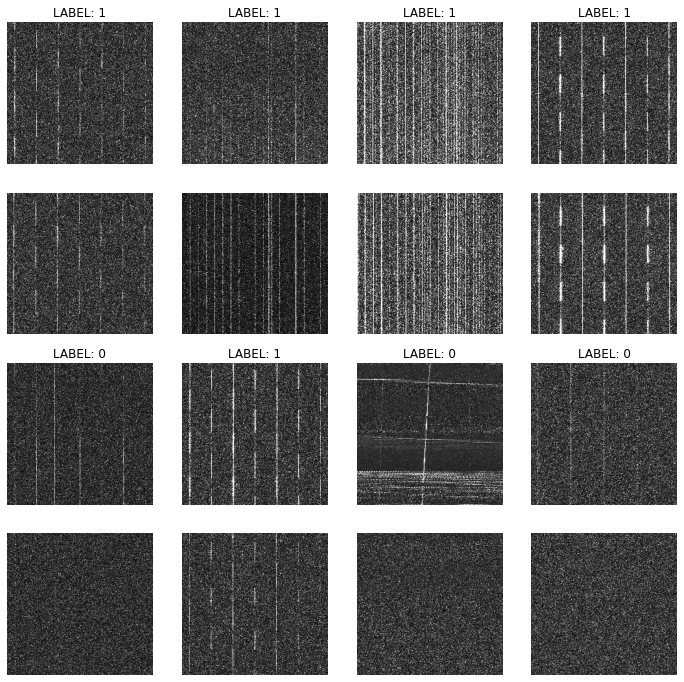

In [8]:
# Show some images from the batch. In this plot, the images are paired 
# verically. This means that the top image corresponds to the first 
# scan image, and the image immediately below it corresponds to the 
# second scan image. Therefore, the plot below shows 8 data points 
# (pairs of images).
show_batch(batch, (4, 4), snr_thresh=5)

<a id='models'></a>
## Building the model

Next, we will use some high-level functions to assmble the model described in Pinchuk & Margot (2021). A more detailed implementation can be found in `models.py`.

In [6]:
from models import get_seti_model

In [7]:
seti_model = get_seti_model(model_name='seti_model', dropout_rate=0.2)

In [8]:
seti_model.summary()

[top](#top)

<a id='eval'></a>
## Model evaluation

Finally, we can load in a model and evalute its perfomance on the data set.

In [8]:
model_dir = pathlib.Path('./final_model')

In [9]:
final_seti_model = tf.keras.models.load_model(model_dir)

In [10]:
all_test_batches = list(test_set.take(-1))
test_data, test_labels = map(
    np.concatenate, 
    zip(*list((x['IMAGES'], x['LABEL']) for x in all_test_batches))
)

In [11]:
# This step can take a while
scores = calculate_scores(
    test_data, 
    final_seti_model,
    shifts=[-4, -3, -2, -1, 0, 1, 2, 3, 4]
)

In [12]:
# Evalute the metrics and store the results
metrics=[
    tf.keras.metrics.Precision(name='Precision'),
    tf.keras.metrics.Recall(name='Recall'), 
    tf.keras.metrics.AUC(name='AUC'),
    tf.keras.metrics.AUC(curve='PR', name='AUPRC')
]
test_result_metrics = {}
for metric in metrics:
    metric.reset_states()
    metric.update_state(test_labels, scores)
    test_result_metrics[f'{metric.name.upper()}'] = metric.result().numpy()
    metric.reset_states()
test_result_metrics['AP'] = average_precision_score(test_labels, scores)

def f1_score(p, r):
    return 2 * (p * r) / (p + r)
test_result_metrics['F1'] = f1_score(test_result_metrics['PRECISION'], test_result_metrics['RECALL'])

In [13]:
for k, v in test_result_metrics.items():
    print(f"{k:>9}: {v*100:4.2f} %") 

PRECISION: 99.15 %
   RECALL: 97.81 %
      AUC: 98.11 %
    AUPRC: 99.82 %
       AP: 99.91 %
       F1: 98.48 %


[top](#top)